In [304]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sp
import pickle, time, os
from scipy.special import logsumexp
from copy import deepcopy

In [323]:
import numpy as np

# ----- geometry (your original parameters, generalized a bit) -----
a1 = np.array([3, np.sqrt(3)])/2
a2 = np.array([3, -np.sqrt(3)])/2
basis = [np.array([0.0, 0.0]), np.array([1.0, 0.0])]   # two sublattice positions: 0 and d1

Lx, Ly = 3, 4
A1 = Lx * a1
A2 = Ly * a2

t1 = 1.0
phi_h = np.arccos(3*np.sqrt(3/43))
t2 = -t1/4/(3*np.sqrt(3/43))

# ----- utility: generate list of positions for sites inside one supercell -----
def generate_supercell_positions(Lx, Ly, a1, a2, basis):
    R = []
    for ix in range(Lx):
        for iy in range(Ly):
            cell_origin = ix*a1 + iy*a2
            for b in basis:
                R.append(cell_origin + b)
    return np.array(R)   # shape (Nsites, 2)

R_list = generate_supercell_positions(Lx, Ly, a1, a2, basis)
Nsites = len(R_list)

# ----- reciprocal (unchanged) -----
def reciprocal_vectors(a1, a2):
    area = a1[0]*a2[1] - a1[1]*a2[0]
    b1 = 2*np.pi*np.array([ a2[1], -a2[0]])/area
    b2 = 2*np.pi*np.array([-a1[1],  a1[0]])/area
    return b1, b2

b1, b2 = reciprocal_vectors(A1, A2)

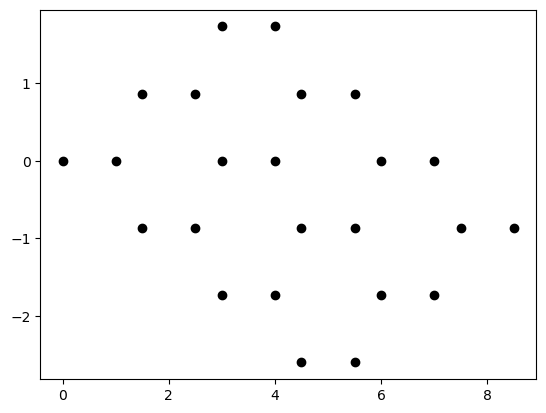

In [324]:
for R in R_list:
    plt.scatter(R[0], R[1], c='k')

In [325]:
# ----- neighbor-finding helpers -----
def find_shell_distances(R_list, A1, A2, image_range=1, tol=1e-6):
    """Return sorted unique distances between distinct sites (across images).
       Useful to identify nearest and next-nearest neighbor distances automatically."""
    dists = []
    N = len(R_list)
    for i in range(N):
        for j in range(N):
            for nx in range(-image_range, image_range+1):
                for ny in range(-image_range, image_range+1):
                    if i == j and nx == 0 and ny == 0:
                        continue
                    d = R_list[j] + nx*A1 + ny*A2 - R_list[i]
                    dists.append(np.linalg.norm(d))
    dists = np.array(dists)
    # cluster unique values up to tol
    uniq = []
    sorted_d = np.sort(dists)
    for val in sorted_d:
        if val <= tol:
            continue
        if not uniq or abs(val - uniq[-1]) > tol:
            uniq.append(val)
    return np.array(uniq)

# Example: get unique distances to pick NN and NNN
shells = find_shell_distances(R_list, A1, A2, image_range=1, tol=1e-6)
# shells[0] is a_nn (nearest neighbor), shells[1] is next-nearest, etc.

In [326]:
# ----- build Hamiltonian in Bloch form H(k) -----
def build_hamiltonian_k(R_list, A1, A2, kvec,
                        t_nn=1.0, t_nnn=0.0, phi_nnn=0.0,
                        image_range=1, tol=1e-6):
    """
    Build H(k) for a supercell with positions R_list (positions of sites inside one cell).
    This sums over translations T = n1*A1 + n2*A2 with -image_range..image_range.
    It automatically classifies NN and NNN by distance shells discovered from geometry.
    For NNN we try to find an intermediate NN path (i -> m -> j) to determine orientation.
    """
    N = len(R_list)
    H = np.zeros((N, N), dtype=np.complex128)
    NN_list = np.zeros((N, N), dtype=bool)
    
    # discover characteristic distances
    shells = find_shell_distances(R_list, A1, A2, image_range=image_range, tol=tol)
    if len(shells) < 1:
        raise RuntimeError("No neighbor shells found; increase image_range.")
    a_nn = shells[0]
    a_nnn = shells[1] if len(shells) > 1 else None

    # Precompute extended positions for searching intermediate sites:
    # We'll need images of all sites in neighboring cells to find intermediate m.
    extended = []
    for base_idx in range(N):
        for nx in range(-image_range, image_range+1):
            for ny in range(-image_range, image_range+1):
                pos = R_list[base_idx] + nx*A1 + ny*A2
                extended.append((base_idx, nx, ny, pos))
    # Build Hamiltonian sums
    for i in range(N):
        ri = R_list[i]
        for j in range(N):
            # sum over translations of cell containing site j
            for nx in range(-image_range, image_range+1):
                for ny in range(-image_range, image_range+1):
                    T = nx*A1 + ny*A2
                    rjT = R_list[j] + T
                    d = rjT - ri
                    dist = np.linalg.norm(d)
                    if dist < tol:
                        # skip self (same site and same translation)
                        continue

                    # --- nearest neighbor ---
                    if np.isclose(dist, a_nn, atol=tol):
                        phase = np.exp(1j * np.dot(kvec, d))
                        H[i, j] += - t_nn * phase
                        NN_list[i, j] = True
                        continue

                    # --- next-nearest neighbor (Haldane-like) ---
                    if a_nnn is not None and np.isclose(dist, a_nnn, atol=tol):
                        # attempt to find an intermediate site m (in extended list)
                        found = False
                        sign = 0.0
                        for (m_base, mx, my, pos_m_ext) in extended:
                            # v1: i -> m_ext
                            v1 = pos_m_ext - ri
                            v2 = rjT - pos_m_ext
                            if (np.isclose(np.linalg.norm(v1), a_nn, atol=tol) and
                                np.isclose(np.linalg.norm(v2), a_nn, atol=tol)):
                                # orientation of the two NN hops i->m and m->j
                                cross_z = np.cross(np.array([v1[0], v1[1], 0.0]),
                                                   np.array([v2[0], v2[1], 0.0]))[2]
                                sign = +1.0 if cross_z > 0 else -1.0
                                found = True
                                break
                        if not found:
                            # fallback: if we can't find an intermediate, use 0 sign (no phase)
                            # (this should be rare for standard lattices if image_range is big enough)
                            sign = 0.0

                        phase = np.exp(1j * (np.dot(kvec, d) + sign * phi_nnn))
                        H[i, j] += - t_nnn * phase
                        continue

                    # else: longer-range: do nothing (or add additional shells if desired)

    return H, NN_list

In [327]:
def get_BZ_points(k_num):
    k_pts_list = []
    for i in range(k_num):
        for j in range(k_num):
            k_pts_list.append(b1*i/k_num + b2*j/k_num)
            #k_pts_list.append(b1*i/k_num + 3*b2*j/k_num)
            
    return k_pts_list

def get_BZ_grid(k_num):
    BZ_grid = np.zeros(shape=(k_num, k_num, 2))
    for i in range(k_num):
        for j in range(k_num):
            BZ_grid[i, j, :] = (b1*i/k_num + b2*j/k_num)
    return BZ_grid

In [328]:
k_num = 30
x = np.zeros(k_num**2)
y = np.zeros_like(x)
bands = np.zeros(shape=(k_num**2, 2*Lx*Ly))

for i, k in enumerate(get_BZ_points(k_num)):
    x[i], y[i] = k
    #bands[i, :] = np.linalg.eigvalsh(H_supercell(k, t1, t2, phi_h))
    H, _ = build_hamiltonian_k(R_list, A1, A2, k, t_nn=t1, t_nnn=t2, phi_nnn=phi_h)
    bands[i, :] = np.linalg.eigvalsh(H)

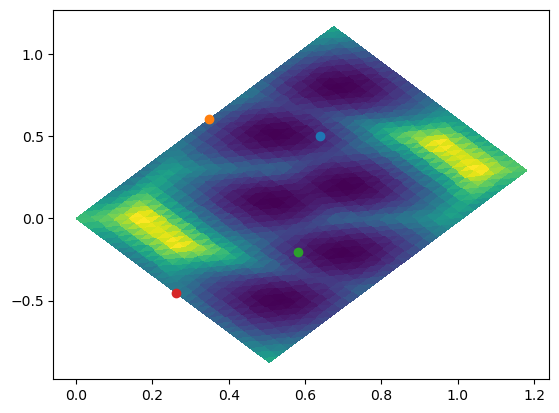

In [329]:
plt.tripcolor(x, y, bands[:, 0])
#plt.xlim(-np.pi/2, np.pi/2)
#plt.ylim(-np.pi/2, np.pi/2)

Γ = np.zeros(2)
K1 = (2*b1+b2)/3
K2 = (b1+2*b2)/3        
M1 = 0.5*b1  
M2 = 0.5*b2

plt.scatter(K1[0], K1[1])
plt.scatter(M1[0], M1[1])
plt.scatter(K2[0], K2[1])
plt.scatter(M2[0], M2[1])

In [330]:
def kpath(Nk_seg=30):
    seg1 = np.linspace(Γ, M1, Nk_seg, endpoint=False)
    seg2 = np.linspace(M1, K1, Nk_seg, endpoint=False)
    seg3 = np.linspace(K1, K2, Nk_seg, endpoint=False)
    seg4 = np.linspace(K2, Γ, Nk_seg, endpoint=True)
    return np.vstack([seg1, seg2, seg3, seg4])


In [331]:
energies = np.zeros(shape=(30*4, 2*Lx*Ly))

for i, k in enumerate(kpath()):
    H, _ = build_hamiltonian_k(R_list, A1, A2, k, t_nn=t1, t_nnn=t2, phi_nnn=phi_h)
    energies[i, :] = np.linalg.eigvalsh(H)

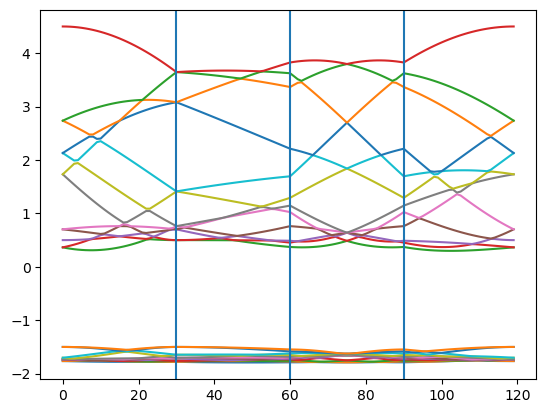

In [332]:
for i in range(2*Lx*Ly):
    plt.plot(energies[:, i])
    
for x in [30, 60, 90]:
    plt.axvline(x=x)
    
#plt.ylim(-1.81, -1.4)

In [253]:


os.environ["OMP_NUM_THREADS"] = "12"     # or the number of physical cores you have
os.environ["MKL_NUM_THREADS"] = "12"     # same variable if you use MKL


# Define basic sparse matrices (CSR format for efficient arithmetic)
sigma_z = sp.dia_matrix(([1, -1], 0), shape=(2, 2), dtype=complex).tocsr()
sigma_minus = sp.csr_matrix(([1], ([1], [0])), shape=(2, 2), dtype=complex)
identity = sp.eye(2, dtype=complex, format='csr')


def generate_sparse_fermionic_operators(N):
    """
    Generate sparse annihilation and creation operators for N orbitals with spin.
    
    Parameters:
    N (int): Number of orbitals.
    
    Returns:
    tuple: (annihilation_ops, creation_ops) where each is a list of 2N sparse matrices.
           The order is [orbital_0↑, orbital_0↓, orbital_1↑, orbital_1↓, ...].
    """
    
    total_modes = N
    annihilation_ops = []
    creation_ops = []
    
    for p in range(total_modes):
        # Initialize operator as a 1x1 identity matrix (to build Kronecker product)
        op = sp.eye(1, dtype=complex, format='csr')
        
        for q in range(total_modes):
            if q < p:
                term = sigma_z
            elif q == p:
                term = sigma_minus
            else:
                term = identity
            
            # Kronecker product with sparse matrices
            op = sp.kron(op, term, format='csr')
        
        annihilation_ops.append(op)
        creation_ops.append(op.conj().transpose())  # Hermitian adjoint
    
    return annihilation_ops, creation_ops

N = 2*Lx*Ly  # Number of orbitals
cs, cdags = generate_sparse_fermionic_operators(N)

In [254]:
def hamil(t1, mu, U, t2, phi_h, k):
    hamiltonian = sp.csr_matrix((2**N, 2**N), dtype=complex)
    NN_ham_mat, NN_list = build_hamiltonian_k(R_list, A1, A2, k, t_nn=t1, t_nnn=t2, phi_nnn=phi_h)
    for i in range(N):
        for j in range(i+1, N):
            if NN_ham_mat[i,j] ==0: continue
            hamiltonian+=cdags[i]@cs[j]*NN_ham_mat[i,j] + cdags[j]@cs[i]*NN_ham_mat[j, i]
            if NN_list[i, j]:
                hamiltonian+=cdags[i]@cs[i]@cdags[j]@cs[j]*U
    for i in range(N):
        hamiltonian+=-(mu)*(cdags[i]@cs[i])
    
    return hamiltonian

def n_filled(H, beta):
    #evals, evecs = full_diag_dense(H)
    evals, evecs = sp.linalg.eigsh(H, k=6, which='SA')
    Z0 = np.exp(-beta*evals).sum()
    return (np.conj(evecs.T)@num_op@ evecs*np.exp(-beta*evals)).real.sum()/Z0


def n_filled_stable(H_csr, beta, num_op):
    #evals, evecs = full_diag_dense(H_csr)
    evals, evecs = sp.linalg.eigsh(H_csr, k=6, which='SA')
    logw = -beta * evals                       # log-weights

    Ndiag = np.diag(evecs.T.conj() @ num_op @ evecs).real
    log_num = logsumexp(logw, b=Ndiag)         # log Σ e^{-βE_i} N_ii
    log_den = logsumexp(logw)                  # log Z

    return np.exp(log_num - log_den)


def n_filled2(H, beta):
    #evals, evecs = full_diag_dense(H)
    evals, evecs = sp.linalg.eigsh(H, k=6, which='SA')
    Z0 = np.exp(-beta*evals).sum()
    return (np.conj(evecs.T)@num_op2@ evecs*np.exp(-beta*evals)).real.sum()/Z0

def n_filled_tot(t1, mu, U, t2, phi_h, beta, k_num):
    acc = 0
    for k in get_BZ_points(k_num):
        hamil_k = hamil(t1, mu, U, t2, phi_h, k)
        #H = np.asfortranarray(hamil_k.toarray(order='F')) 
        acc+=n_filled_stable(hamil_k, beta, num_op)
    return acc/k_num/k_num

def compressibility(mu, t, U, beta, k_num):
    acc = 0
    for k in get_redBZ_points(k_num):
        hamil_k = hamil(t, mu, U, k, True)
        #H = np.asfortranarray(hamil_k.toarray(order='F')) 
        #acc+=n_filled2(H, beta) -n_filled(H, beta)**2
        acc+=n_filled_stable(hamil_k, beta, num_op2) - n_filled_stable(hamil_k, beta, num_op)**2
    return acc*beta/Lx/Ly/k_num/k_num

In [255]:
num_op = sp.csr_matrix((2**N, 2**N), dtype=complex)
for i in range(N):
    num_op+=cdags[i]@cs[i]

In [1]:
k_num = 10



U_list = np.array([40])
beta_list = np.array([100])
n_mu_pts = 30

filling_list = np.zeros(shape=(len(U_list), len(beta_list), n_mu_pts))

for U_ind, U in enumerate(U_list):
    print(U)
    for beta_ind, beta in enumerate(beta_list):
        mu_list = np.linspace(-1, 6, n_mu_pts)
        for mu_ind, mu in enumerate(mu_list):
            filling_list[U_ind, beta_ind, mu_ind] = n_filled_tot(t1, mu, U, t2, phi_h, beta, k_num)
            print(mu_ind)

NameError: name 'np' is not defined

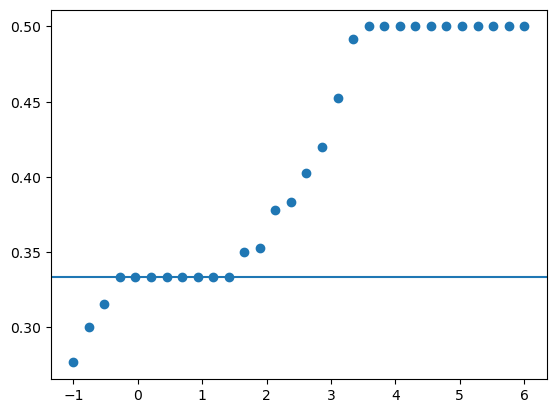

In [313]:
plt.scatter(mu_list, filling_list[0,0,:]/(2*Lx*Ly))
plt.axhline(y=0.3333)
#plt.axhline(y=0.25)

In [314]:
U = 20
beta = 100
mu = 0.5

N_eigs = 10

energies = np.zeros(shape=(30*4, N_eigs))

for i, k in enumerate(kpath()):
    hamil_k = hamil(t1, mu, U, t2, phi_h, k)
    evals, evecs = sp.linalg.eigsh(hamil_k, k=N_eigs, which='SA')
    energies[i, :] = np.sort(evals)

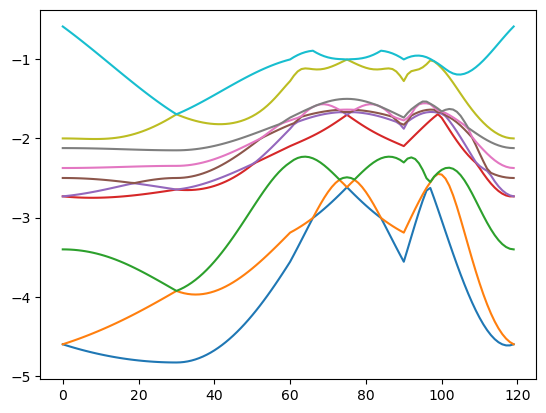

In [315]:
for i in range(N_eigs):
    plt.plot(energies[:, i])
    
#plt.ylim(-8.6, -8.1)

In [263]:
energies[0, :]

array([-3.60106930e+00, -3.60106930e+00, -2.40198033e+00, -2.23205081e+00,
       -2.23205081e+00, -2.00000000e+00, -1.00000000e+00, -8.73834158e-01,
       -6.22116922e-01, -1.42538605e-15])

In [321]:
U = 20
mu = 0

k_num = 20

N_eigs = 5
gs_list = []

gs_evec_list = np.zeros(shape=(k_num,k_num, 2**(2*Lx*Ly)), dtype=complex)
degen_vec_list = []
degen_vec_index = []

BZ_grid = get_BZ_grid(k_num)
x, y = [], []

for i in range(k_num):
    for j in range(k_num):
        k = BZ_grid[i, j, :]
        hamil_k = hamil(t1, mu, U, t2, phi_h, k)
        evals, evecs = sp.linalg.eigsh(hamil_k, k=N_eigs, which='SA')
        idx = np.argsort(evals)
        evals = evals[idx]
        evecs = evecs[:, idx]

        gs_evec_list[i, j, :] = evecs[:, 0]
        if np.abs(evals[0]-evals[1])<1e-10:
            degen_vec_list.append(evecs[:, 1])
            degen_vec_index.append([i, j])


In [322]:
phase=0
particle_number = 0

for i in range(k_num):
    for j in range(k_num):
        psi1 = gs_evec_list[i, j, :]
        psi2 = gs_evec_list[(i+1)%k_num, j, :]
        psi3 = gs_evec_list[i, (j+1)%k_num, :]
        psi4 = gs_evec_list[(i+1)%k_num, (j+1)%k_num, :]

        plaq_phase = np.angle(np.vdot(psi1, psi2)*np.vdot(psi2, psi4)*np.vdot(psi4, psi3)*np.vdot(psi3, psi1)/
                             np.abs(np.vdot(psi1, psi2)*np.vdot(psi2, psi4)*np.vdot(psi4, psi3)*np.vdot(psi3, psi1)))
        phase += plaq_phase
        particle_number+=np.vdot(psi1, num_op@psi1)

for n_evec in range(1, 2**len(degen_vec_index)):
    temp_evec_list = deepcopy(gs_evec_list)
    binary_string = format(n_evec, f'0{len(degen_vec_index)}b')
    binary_string = [binary_string[i] for i in range(len(binary_string))]
    for ind, item in enumerate(binary_string):
        if item=='1':      
            temp_evec_list[*degen_vec_index[ind]] = degen_vec_list[ind]
    for i in range(k_num):
        for j in range(k_num):
            psi1 = temp_evec_list[i, j, :]
            psi2 = temp_evec_list[(i+1)%k_num, j, :]
            psi3 = temp_evec_list[i, (j+1)%k_num, :]
            psi4 = temp_evec_list[(i+1)%k_num, (j+1)%k_num, :]

            plaq_phase = np.angle(np.vdot(psi1, psi2)*np.vdot(psi2, psi4)*np.vdot(psi4, psi3)*np.vdot(psi3, psi1)/
                                 np.abs(np.vdot(psi1, psi2)*np.vdot(psi2, psi4)*np.vdot(psi4, psi3)*np.vdot(psi3, psi1)))
            phase += plaq_phase
            particle_number+=np.vdot(psi1, num_op@psi1)

            #phase_grid.append(phase)
print(phase/2/np.pi)

-2048.0000000014716


In [318]:
4096/2**11

2.0